In [66]:
import pandas, os, re, sys, importlib, random, functools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import configuration
import write_excel
import configuration_commands

import simple.targets
import simple.simple_overlap
import simple.ManyToManyTranslator
#import simple.overlapDictInfo
import simple.polyglot
import simple.utils

import complexTargetSet




"""
Configuration file is a list of entries of this form:
FbfOO25C=[<
    filename=/Users/dfporter/Desktop/macbook_air_Desktop/shared/sp_oo/FBF_gendered_gl/tables/Table S1 Peaks.xls
    language=gene_name
    species=worm
    load_sheets_of_excel=True
    sheetnames=OO FBF (25°C)
    column_name=Gene name
    >]
Top500FbfOO25C=[<
    filename=/Users/dfporter/Desktop/macbook_air_Desktop/shared/sp_oo/FBF_gendered_gl/tables/Table S1 Peaks.xls
    language=gene_name
    species=worm
    load_sheets_of_excel=True
    sheetnames=OO FBF (25°C)
    column_name=Gene name
    subset=True
    subset_function=lambda x: x['Rank']<501
    >]
    
The subset_function parameter will be executed as python code to define a function.
The subsetting function will be run to subset rows of the input file.

"""



"\nConfiguration file is a list of entries of this form:\nFbfOO25C=[<\n    filename=/Users/dfporter/Desktop/macbook_air_Desktop/shared/sp_oo/FBF_gendered_gl/tables/Table S1 Peaks.xls\n    language=gene_name\n    species=worm\n    load_sheets_of_excel=True\n    sheetnames=OO FBF (25°C)\n    column_name=Gene name\n    >]\nTop500FbfOO25C=[<\n    filename=/Users/dfporter/Desktop/macbook_air_Desktop/shared/sp_oo/FBF_gendered_gl/tables/Table S1 Peaks.xls\n    language=gene_name\n    species=worm\n    load_sheets_of_excel=True\n    sheetnames=OO FBF (25°C)\n    column_name=Gene name\n    subset=True\n    subset_function=lambda x: x['Rank']<501\n    >]\n    \nThe subset_function parameter will be executed as python code to define a function.\nThe subsetting function will be run to subset rows of the input file.\n\n"

In [67]:

def reload_modules():
    importlib.reload(configuration)
    importlib.reload(configuration_commands)
    importlib.reload(simple.polyglot)
    importlib.reload(simple.ManyToManyTranslator)
    importlib.reload(simple.simple_overlap)
    importlib.reload(simple.overlapDictInfo)
    importlib.reload(simple.utils)

In [68]:
reload_modules()
print('')
config = configuration.configuration(configuration_commands.config_text)
df = simple.polyglot.polyglot.make_polyglot_file(config)
print('Done.')



Making polyglot file.
Reading ortholist file, line:  0
Reading ortholist file, line:  1000
Reading ortholist file, line:  2000
Reading ortholist file, line:  3000
Reading ortholist file, line:  4000
Reading ortholist file, line:  5000
Reading ortholist file, line:  6000
Reading ortholist file, line:  7000
Collapsing a list of paired sets, length 7647.
On iteration 1.
Collapsed to length 4891
There were 7647 unique items in the first position, and 11533 in the second.
After collapse, there were 7647 and 11533 items. (Should be the same.)
On iteration 2.
Collapsed to length 4831
There were 7647 unique items in the first position, and 11533 in the second.
After collapse, there were 7647 and 11533 items. (Should be the same.)
Fully collapsed.
Collapsing a list of paired sets, length 4831.
On iteration 1.
Collapsed to length 4831
There were 11533 unique items in the first position, and 7647 in the second.
After collapse, there were 11533 and 7647 items. (Should be the same.)
Fully collapse

In [69]:

for_file = df.copy()
for col in for_file.columns:
    for_file[col] = [', '.join(list(_set)) for _set in for_file[col]]
for_file.to_excel('./output/polyglot.xlsx')

In [122]:
reload_modules()

pg = simple.polyglot.polyglot(df)

def polyglot_stats(self):
    pg.df['has Human ENSG'] = [(len(x)>0) for x in pg.df['Human ENSG']]
    pg.df['has Human gene symbol'] = [(len(x)>0) for x in pg.df['Human gene symbol']]
    pg.df['has Worm public name'] = [(len(x)>0) for x in pg.df['Worm public name']]
    print(self.df.columns)
    print(pg.df['has Human ENSG'].value_counts())
    print(pg.df['has Human gene symbol'].value_counts())
    print(pg.df['has Worm public name'].value_counts())

pg.polyglot_stats = polyglot_stats
pg.polyglot_stats(pg)

Index(['Human ENSG', 'Human gene symbol', 'Worm public name', 'has Human ENSG',
       'has Human gene symbol', 'has Worm public name',
       'FBF targets (Worm public name)', 'Randoms',
       'PUM targets (Human gene symbol)', 'Gene description'],
      dtype='object')
True     4717
False       8
Name: has Human ENSG, dtype: int64
True     4690
False      35
Name: has Human gene symbol, dtype: int64
True    4725
Name: has Worm public name, dtype: int64


In [141]:
reload_modules()

config = configuration.configuration(configuration_commands.config_text)


def add_gene_description(polyglot_obj):
    table = '/Users/dfporter/Desktop/macbook_air_Desktop/shared/sp_oo/'
    table += 'FBF_gendered_gl/tables/name_description_235.txt'

    df_lookup = pandas.read_csv(table, sep='\t', index_col=False)

    lookup = dict(zip(df_lookup['Gene name'], df_lookup['Gene description']))
    
    def parse_set(worm_gene_name_set):
        for name in list(worm_gene_name_set):
            if name in lookup:
                return lookup[name]
        return ''
    
    polyglot_obj.df['Gene description'] = [
        parse_set(x) for x in polyglot_obj.df['Worm public name']]
    

def compare_with_n_randoms(
    pum=None, linguist=None, n_to_pick=174):
    
    linguist.add_a_column_of_random_targets(
        'Worm public name', col_name='FBF targets (Worm public name)', n_to_pick=n_to_pick)

    linguist.add_a_column_of_targets(
        pum.targets, 'Human gene symbol', 'PUM targets (Human gene symbol)')

    tups = simple.simple_overlap.simple_overlap(
        linguist, 
        #col1='Randoms',
        col1='FBF targets (Worm public name)', 
        col2='PUM targets (Human gene symbol)', verbose=True)

def compare_two_target_lists(
    fname1='FbfOO25C', fname2='Hafner', 
    use_this_pum=None, use_this_fbf=None,
    config=None, linguist=None):
    
    if use_this_fbf is not None:
        fbf = use_this_fbf
    else:
        fbf = config.targets_from_config(fname1)

    fbf.targets = set(list(fbf.targets)) - set([''])
    
    #linguist.add_a_column_of_targets(
    #    fbf.targets, 'Worm public name', 'FBF targets (Worm public name)')
    #fbf.make_cgenes(orthos)  # .cgenes in human ENSG, .targets in worm gene names.
    #print(fbf.cgenes, '---')

    linguist.add_a_column_of_random_targets(
        'Worm public name', col_name='FBF targets (Worm public name)', n_to_pick=174)
    
    if not use_this_pum:
        pum = config.targets_from_config(fname2)  # .targets in human gene symbol.
    else:
        pum = use_this_pum

    linguist.add_a_column_of_targets(
        pum.targets, 'Human gene symbol', 'PUM targets (Human gene symbol)')

    tups = simple.simple_overlap.simple_overlap(
        linguist, 
        #col1='Randoms',
        col1='FBF targets (Worm public name)', 
        col2='PUM targets (Human gene symbol)', verbose=True)
    
    add_gene_description(linguist)
    
    return tups


hafner_pum = config.targets_from_config('Hafner')
hafner_pum.name = 'Hafner'
lin_pum = config.targets_from_config('Lin_pum')
lin_pum.name = 'Lin_pum'
#gld1_raj = config.targets_from_config('gld1_raj')
#gld1_raj.name = 'gld1_raj'
#print(gld1_raj.targets)

FBF_cols = [
    'FbfOO25C', 'Top500FbfOO25C', 
    'FbfSP25C', 'Top500FbfSP25C', 
    'Fbf1_20C', 'Top500Fbf1_20C', 'Fbf2_20C', 'Top500Fbf2_20C', 
    'BlockI', 'BlockII', 'BlockIII',
]

dict_of_sets_dfs = {}
list_of_stats_dicts = []
n_comparison = 0
tups = []
results = {}

for fbf_col in FBF_cols:
    for pum in [hafner_pum, lin_pum]:

        n_comparison += 1
        print("On comparison {0}/{1}.".format(n_comparison, len(FBF_cols) * 2))
        
        tups = compare_two_target_lists(
            fname1=fbf_col, fname2=pum.name,
            linguist=pg, config=config,
            #use_this_fbf=gld1_raj,
            use_this_pum=pum)
        
        results[fbf_col + ' vs ' + pum.name] = tups
        dict_of_sets_dfs[fbf_col + ' vs ' + pum.name] = pg.df.copy()
        #list_of_stats_dicts.append(stats_dict)
        
        #break
    #break

skip_gld1 = '''
for pum in [hafner_pum, lin_pum]:
    tups = compare_two_target_lists(
        fname1='GLD-1', fname2=pum.name,
        linguist=pg, config=config,
        use_this_fbf=gld1_raj,
        use_this_pum=pum)

    results['GLD-1' + ' vs ' + pum.name] = tups
    dict_of_sets_dfs['GLD-1' + ' vs ' + pum.name] = pg.df.copy()
'''
print('Done.')
print(results.keys())


/Users/dfporter/pma/venv/lib/python3.6/site-packages/pandas/util/_decorators.py:118: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)
/Users/dfporter/Desktop/macbook_air_Desktop/shared/sp_oo/FBF_gendered_gl/orthos/simple/targets.py:63: UserWarning: Non-string data type <class 'float'> for target nan in /Users/dfporter/Desktop/macbook_air_Desktop/shared/sp_oo/FBF_gendered_gl/orthos/lib/supp_gad.298752.117_SUPPLEMENTAL_Table2sites.xlsx. Skipping.
  type(target), target, self.fname))


On comparison 1/22.
On comparison 2/22.
On comparison 3/22.
Before running rule  2139
After rule  500
On comparison 4/22.
Before running rule  2139
After rule  500
On comparison 5/22.
On comparison 6/22.
On comparison 7/22.
Before running rule  2131
After rule  500
On comparison 8/22.
Before running rule  2131
After rule  500
On comparison 9/22.
On comparison 10/22.
On comparison 11/22.
Before running rule  2364
After rule  500
On comparison 12/22.
Before running rule  2364
After rule  500
On comparison 13/22.
On comparison 14/22.
On comparison 15/22.
Before running rule  2835
After rule  500
On comparison 16/22.
Before running rule  2835
After rule  500
On comparison 17/22.
On comparison 18/22.
On comparison 19/22.
On comparison 20/22.
On comparison 21/22.
On comparison 22/22.
Done.
dict_keys(['FbfOO25C vs Hafner', 'FbfOO25C vs Lin_pum', 'Top500FbfOO25C vs Hafner', 'Top500FbfOO25C vs Lin_pum', 'FbfSP25C vs Hafner', 'FbfSP25C vs Lin_pum', 'Top500FbfSP25C vs Hafner', 'Top500FbfSP25C vs 

In [142]:
#print(results['FbfOO25C vs gld1_raj'])
for k, v in dict_of_sets_dfs.items():
    print(k)
    v.sort_values(by='FBF targets (Worm public name)', ascending=False, inplace=True)
    print(v.head(20))

FbfOO25C vs Hafner
                                             Human ENSG  \
2392                 (ENSG00000141644, ENSG00000154832)   
2628                                  (ENSG00000124380)   
2641  (ENSG00000198951, ENSG00000268815, ENSG0000010...   
1457  (ENSG00000185057, ENSG00000085231, ENSG0000021...   
1990                                  (ENSG00000198231)   
1685  (ENSG00000234920, ENSG00000206445, ENSG0000022...   
2266  (ENSG00000142694, ENSG00000115363, ENSG0000016...   
2265  (FLJ44817, ENSG00000175985, ENSG00000023892, E...   
3299                 (ENSG00000021762, ENSG00000091039)   
3755  (ENSG00000170684, ENSG00000119866, ENSG0000012...   
3647  (ENSG00000100379, ENSG00000214264, ENSG0000010...   
4470                 (ENSG00000131051, ENSG00000100461)   
1591                                  (ENSG00000186591)   
2525                                  (ENSG00000005156)   
141                  (ENSG00000146731, ENSG00000132141)   
1592                                 

In [143]:
import simple.utils
writer = pandas.ExcelWriter(path='./output/File S7 Conservation.xlsx')

workbook  = writer.book
format2 = workbook.add_format({'num_format': '0%'})

for k, v in dict_of_sets_dfs.items():
    arr = [(len(x)>0) for x in v['FBF targets (Worm public name)'].tolist()]
    _v = v.loc[arr].copy()

    for col in [
        'has Human ENSG', 'has Human gene symbol', 'has Worm public name']:
        del _v[col]
    if 'targs' in _v.columns:
        del _v['targs']
    for col in ['Human ENSG', 'Human gene symbol', 'Worm public name', 
               'FBF targets (Worm public name)', 'PUM targets (Human gene symbol)']:
        _v[col] = [", ".join(list(x)) for x in _v[col]]
        
    tab_name = simple.utils.label_cleaner(k)
    
    _v.to_excel(writer, sheet_name=tab_name, index=False)
    worksheet = writer.sheets[tab_name]
    worksheet.set_column('A:G', 18)


writer.save()


In [144]:
for name, tups in results.items():
    print(name)
    print([(k,v) for k,v in tups[2]['Orthologs of FBF targets (Ensembl)'].items() if v>1])

FbfOO25C vs Hafner
[]
FbfOO25C vs Lin_pum
[]
Top500FbfOO25C vs Hafner
[]
Top500FbfOO25C vs Lin_pum
[]
FbfSP25C vs Hafner
[]
FbfSP25C vs Lin_pum
[]
Top500FbfSP25C vs Hafner
[]
Top500FbfSP25C vs Lin_pum
[]
Fbf1_20C vs Hafner
[]
Fbf1_20C vs Lin_pum
[]
Top500Fbf1_20C vs Hafner
[]
Top500Fbf1_20C vs Lin_pum
[]
Fbf2_20C vs Hafner
[]
Fbf2_20C vs Lin_pum
[]
Top500Fbf2_20C vs Hafner
[]
Top500Fbf2_20C vs Lin_pum
[]
BlockI vs Hafner
[]
BlockI vs Lin_pum
[]
BlockII vs Hafner
[]
BlockII vs Lin_pum
[]
BlockIII vs Hafner
[]
BlockIII vs Lin_pum
[]


In [145]:
def form_dataframe(results):
    rows = []
    for name, tups in results.items():
        from_sets = dict([(k, len(v)) for k, v in zip(tups[0].keys(), tups[0].values())])
        collapsed = tups[1]
        uncollapsed = tups[2]

        for k in from_sets:
            try:
                uncollapsed[k] = len(uncollapsed[k])
            except:
                pass
                #print('\tfrom uncollapsed', uncollapsed[k])
            if uncollapsed[k] != from_sets[k]:
                print("UH OH")
    
        collapsed = dict([('(Homologs collapsed) ' + k, v) for k, v in collapsed.items()])
        uncollapsed = dict([('(Homologs uncollapsed) ' + k, v) for k, v in uncollapsed.items()])
        collapsed.update(uncollapsed)
        collapsed.update({'Name': name})
        rows.append(collapsed)
        
    _df = pandas.DataFrame(rows)
    _df['(Homologs collapsed) % translatable FBF targets shared'] = [
        int(1000 * (x/y))/10 for x,y in zip(
        _df['(Homologs collapsed) FBF targets shared (Worm public name)'], _df[
            '(Homologs collapsed) FBF targets (Worm public name)'])
    ]    
    _df['(Homologs uncollapsed) % translatable FBF targets shared'] = [
        int(1000 * (x/y))/10 for x,y in zip(
        _df['(Homologs uncollapsed) FBF targets shared (Worm public name)'], _df[
            '(Homologs uncollapsed) FBF targets (Worm public name)'])
    ]  
    _df['(Homologs collapsed) % translatable PUM targets shared'] = [
        int(1000 * (x/y))/10 for x,y in zip(
        _df['(Homologs collapsed) PUM targets shared (Human gene symbols)'], _df[
            '(Homologs collapsed) PUM targets (Human gene symbols)'])
    ]    
    _df['(Homologs uncollapsed) % translatable PUM targets shared'] = [
        int(1000 * (x/y))/10 for x,y in zip(
        _df['(Homologs uncollapsed) PUM targets shared (Human gene symbols)'], _df[
            '(Homologs uncollapsed) PUM targets (Human gene symbols)'])
    ] 
    _df['(Homologs collapsed) % translatable worm genes shared'] = [
        int(1000 * (x/y))/10 for x,y in zip(
        _df['(Homologs collapsed) Orthologs of PUM targets (Worm public name)'], _df[
            '(Homologs collapsed) Worm public names with homologs'])        
    ]
    _df['(Homologs uncollapsed) % translatable worm genes with homolog bound by PUM'] = [
        int(1000 * (x/y))/10 for x,y in zip(
        _df['(Homologs uncollapsed) Orthologs of PUM targets (Worm public name)'], _df[
            '(Homologs uncollapsed) Worm public names with homologs'])        
    ]
    _df['(Homologs collapsed) % translatable human genes with homolog bound by FBF'] = [
        int(1000 * (x/y))/10 for x,y in zip(
        _df['(Homologs collapsed) Orthologs of FBF targets (Human gene symbol)'], _df[
            '(Homologs collapsed) Human gene symbols with homologs'])        
    ]
    return _df


import copy
copyresults = copy.deepcopy(results)
_df = form_dataframe(copy.deepcopy(results))

In [146]:
print(_df.iloc[0])
_df.to_excel('output/summary_of_conservation.xlsx')

(Homologs collapsed) FBF targets (Worm public name)                                          130
(Homologs collapsed) FBF targets shared (Worm public name)                                    37
(Homologs collapsed) Human gene symbol                                                      4725
(Homologs collapsed) Human gene symbols with homologs                                       4690
(Homologs collapsed) Orthologs of FBF targets (Ensembl)                                      130
(Homologs collapsed) Orthologs of FBF targets (Human gene symbol)                            130
(Homologs collapsed) Orthologs of PUM targets (Ensembl)                                     1334
(Homologs collapsed) Orthologs of PUM targets (Worm public name)                            1334
(Homologs collapsed) Orthologs of shared targets (Ensembl)                                    37
(Homologs collapsed) PUM targets (Human gene symbols)                                       1334
(Homologs collapsed) PUM targe

In [147]:
writer = pandas.ExcelWriter('output/File S7 conservation.xls')
bakup_df = _df.copy()
_df.index = _df.Name
all_worm_genes_hafner = pandas.DataFrame(
    [{
        'Name': 'All translatable worm genes vs Hafner',
        #'Name': '(Homologs collapsed) % translatable worm genes with homolog bound by PUM (Hafner)',
      
        # (This value is all translatable worm RNAs, not FBF targets;
        # the index name here is used for plottting with the FBF sets.
        # This is calculated from:
        # (Homologs collapsed) Orthologs of PUM targets (Worm public name)
        # divided by '(Homologs collapsed) Worm public names with homologs'
      '(Homologs collapsed) % translatable FBF targets shared': _df.loc['FbfOO25C vs Hafner'][
          '(Homologs collapsed) % translatable worm genes shared'],
      
      '(Homologs collapsed) FBF targets shared (Worm public name)': _df.loc['FbfOO25C vs Hafner'][
          '(Homologs collapsed) Orthologs of PUM targets (Worm public name)'],
      
      '(Homologs collapsed) % translatable worm genes shared': _df.loc['FbfOO25C vs Hafner'][
          '(Homologs collapsed) % translatable worm genes shared'],
    
        '(Homologs collapsed) % translatable PUM targets shared': _df.loc['FbfOO25C vs Hafner'][
           '(Homologs collapsed) % translatable worm genes shared'
        ]
        
      
     }],
#    columns=['Name']
    #index=['All translatable worm genes vs Hafner']
)
all_worm_genes_lin = pandas.DataFrame(
    [{
        'Name': 'All translatable worm genes vs Lin',
        #'Name': '(Homologs collapsed) % translatable worm genes with homolog bound by PUM (Hafner)',
      
        # (This value is all translatable worm RNAs, not FBF targets;
        # the index name here is used for plottting with the FBF sets.
        # This is calculated from:
        # (Homologs collapsed) Orthologs of PUM targets (Worm public name)
        # divided by '(Homologs uncollapsed) Worm public names with homologs'
      '(Homologs collapsed) % translatable FBF targets shared': _df.loc['FbfOO25C vs Lin_pum'][
          '(Homologs collapsed) % translatable worm genes shared'],
      
      '(Homologs collapsed) FBF targets shared (Worm public name)': _df.loc['FbfOO25C vs Lin_pum'][
          '(Homologs collapsed) Orthologs of PUM targets (Worm public name)'],
      
      '(Homologs collapsed) % translatable worm genes shared': _df.loc['FbfOO25C vs Lin_pum'][
          '(Homologs collapsed) % translatable worm genes shared'],
    
        '(Homologs collapsed) % translatable PUM targets shared': _df.loc['FbfOO25C vs Lin_pum'][
           '(Homologs collapsed) % translatable worm genes shared'
        ]
     }],
#    columns=['Name']
)

_rows = _df.to_dict('records')
_rows.append(all_worm_genes_hafner.to_dict('records')[0])
_rows.append(all_worm_genes_lin.to_dict('records')[0])

appdf = pandas.DataFrame(_rows)

appdf.index = appdf.Name

#for col in _df.Name:
#    print("'{0}',".format(col))

/Users/dfporter/pma/venv/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


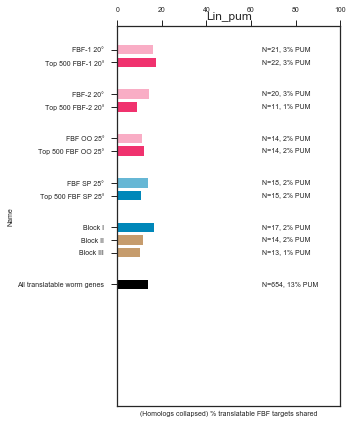

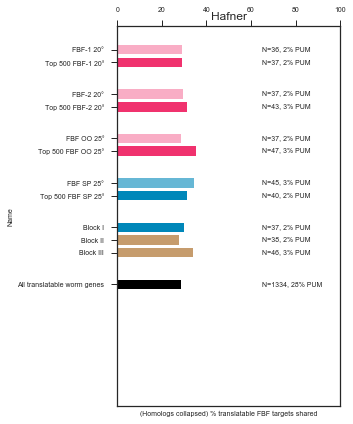

In [148]:
import seaborn as sns
import matplotlib.pyplot as plt



_hafner = [
    'Fbf1_20C vs Hafner',
    'Top500Fbf1_20C vs Hafner',

    'Fbf2_20C vs Hafner',
    'Top500Fbf2_20C vs Hafner',

    'FbfOO25C vs Hafner',
    'Top500FbfOO25C vs Hafner',

    'FbfSP25C vs Hafner',
    'Top500FbfSP25C vs Hafner',

    'BlockI vs Hafner',
    'BlockII vs Hafner',
    'BlockIII vs Hafner',
    
    'All translatable worm genes vs Hafner'
]
_lin = [
    'Fbf1_20C vs Lin_pum',
    'Top500Fbf1_20C vs Lin_pum',

    'Fbf2_20C vs Lin_pum',
    'Top500Fbf2_20C vs Lin_pum',

    'FbfOO25C vs Lin_pum',
    'Top500FbfOO25C vs Lin_pum',

    'FbfSP25C vs Lin_pum',
    'Top500FbfSP25C vs Lin_pum',
    
    'BlockI vs Lin_pum',
    'BlockII vs Lin_pum',
    'BlockIII vs Lin_pum',
    
    'All translatable worm genes vs Lin'
]

def refresh():
    plt.clf()
    plt.close()
    
    

def barploter(df, figname='../figs/barploty.pdf'):
    
    # Y positioning.
    barw = 0.3
    spacer = barw + 0.1
    init = -0.15
    step = 1
    init_spacer_step = init + spacer + step
    y_pos = [
        init,  # 1
        init + spacer,
        init_spacer_step,  # 3
        init_spacer_step + spacer,
        init_spacer_step + spacer + step,  # 5
        init_spacer_step + 2*spacer + step,
        init_spacer_step + 2*spacer + 2*step,  # 7
        init_spacer_step + 3*spacer + 2*step,
        init_spacer_step + 3*spacer + 3*step,  # 9
        init_spacer_step + 4*spacer + 3*step,
        init_spacer_step + 5*spacer + 3*step,  # 11
        init_spacer_step + 5*spacer + 4*step,

    ]
    bar_colors = [
        '#F9ADC5', '#F0326E',
        '#F9ADC5', '#F0326E',
        '#F9ADC5', '#F0326E',
        '#66B7D5', '#0087B9',
        #'#D1A9CF', '#8D2787',
        '#0087B9',
        '#C69C6D', '#C69C6D',
        '#000000'
                 ]
    
    # Plot the bars.
    sns.set(font_scale=1)
    sns.set_style("ticks")
    refresh()
    fig = plt.figure()
    ax = sns.barplot(
        x='(Homologs collapsed) % translatable FBF targets shared', y='Name', data=df,
    )
    fig.set_figheight(7)
    fig.set_figwidth(4)
    
    ax.set_xlim(0, 100)
    
    # Change y positions and colors.
    new_bars_y_positions = []

    for bar, guess_y, bar_color in zip(ax.patches, y_pos, bar_colors):
        newwidth=0.3
        bar.set_y(guess_y)
        x = bar.get_y()
        width = bar.get_height()
        centre = x+width/2.

        bar.set_y(centre-newwidth/2.)
        bar.set_height(newwidth)
        new_bars_y_positions.append(bar.get_y() + newwidth/2)
        
        bar.set_facecolor(bar_color)
    ax.set_yticks(new_bars_y_positions)
    title = ax.get_yticklabels()[0]._text.split(' vs ')[-1]
    ax.set_yticklabels([
        simple.utils.label_cleaner(x._text.split(' vs ')[0]) for x in ax.get_yticklabels()])
    ax.set_title(title)
    
    ax.tick_params(labelsize=7)
    ax.set_xlabel(ax.get_xlabel(), fontsize=7)
    ax.set_ylabel(ax.get_ylabel(), fontsize=7)
    ax.xaxis.tick_top()
    
    # Add annotations.
    for p, n, percpum in zip(
        ax.patches,
        df['(Homologs collapsed) FBF targets shared (Worm public name)'],
        df['(Homologs collapsed) % translatable PUM targets shared']):
        
        ax.annotate("N={0}, {1}% PUM".format(n, int(percpum)),
            (p.get_x() + 65,#p.get_width() + 20, 
             p.get_y() + (p.get_height()/2)),
             ha='left', va='center', rotation=0,
            fontsize=7,
        ) 
    #ax.set_ylim(ax.get_ylim()[0] - 4, ax.get_ylim()[1])

    fig.savefig(figname)
    plt.show()
    refresh()

overlaps = appdf.copy()

barploter(appdf.loc[_lin], figname='../figs/shared_with_Lin_PUM.pdf')
barploter(appdf.loc[_hafner], figname='../figs/shared_with_Hafner_PUM.pdf')
overlaps.to_excel('output/overlaps_results.xlsx')



In [149]:
print(overlaps['(Homologs collapsed) % translatable FBF targets shared'])


Name
FbfOO25C vs Hafner                       28.4
FbfOO25C vs Lin_pum                      10.9
Top500FbfOO25C vs Hafner                 35.3
Top500FbfOO25C vs Lin_pum                11.9
FbfSP25C vs Hafner                       34.3
FbfSP25C vs Lin_pum                      14.0
Top500FbfSP25C vs Hafner                 31.2
Top500FbfSP25C vs Lin_pum                10.5
Fbf1_20C vs Hafner                       29.0
Fbf1_20C vs Lin_pum                      15.9
Top500Fbf1_20C vs Hafner                 28.9
Top500Fbf1_20C vs Lin_pum                17.4
Fbf2_20C vs Hafner                       29.6
Fbf2_20C vs Lin_pum                      14.3
Top500Fbf2_20C vs Hafner                 31.3
Top500Fbf2_20C vs Lin_pum                 9.0
BlockI vs Hafner                         29.8
BlockI vs Lin_pum                        16.6
BlockII vs Hafner                        27.7
BlockII vs Lin_pum                       11.5
BlockIII vs Hafner                       33.8
BlockIII vs Lin_pum          